Copyright (c) Meta Platforms, Inc. and affiliates.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/co-tracker/blob/main/notebooks/demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# CoTracker: It is Better to Track Together
This is a demo for <a href="https://co-tracker.github.io/">CoTracker</a>, a model that can track any point in a video.

<img src="https://www.robots.ox.ac.uk/~nikita/storage/cotracker/bmx-bumps.gif" alt="Logo" width="50%">

Let's install dependencies:

In [1]:
import os
import cv2
import torch

from torchvision.io import read_video
from cotracker.utils.visualizer import Visualizer
from IPython.display import HTML

Read a video from CO3D:

In [2]:
video = read_video('../assets/apple.mp4')[0]
video = video.permute(0, 3, 1, 2)[None].float()

In [3]:
HTML("""<video width="640" height="480" autoplay loop controls>
            <source src="../assets/apple.mp4" type="video/mp4">
        </video>""")

Import CoTrackerPredictor and create an instance of it. We'll use this object to estimate tracks:

In [4]:
from cotracker.predictor import CoTrackerPredictor

model = CoTrackerPredictor(
    checkpoint=os.path.join(
        '../checkpoints/cotracker_stride_4_wind_8.pth'
    )
)

Track points sampled on a regular grid of size 30\*30 on the first frame:

In [5]:
pred_tracks, pred_visibility = model(video, grid_size=30)

Visualize and save the result: 

In [6]:
vis = Visualizer(save_dir='./videos', pad_value=100)
vis.visualize(video=video, tracks=pred_tracks, filename='teaser');

Video saved to ./videos/teaser_pred_track.mp4


In [7]:
HTML("""<video width="640" height="480" autoplay loop controls>
            <source src="./videos/teaser_pred_track.mp4" type="video/mp4">
        </video>""")

## Tracking manually selected points

We will start by tracking points queried manually.
We define a queried point as: [time, x coord, y coord] 

So, the code below defines points with different x and y coordinates sampled on frames 0, 10, 20, and 30:

In [8]:
queries = torch.tensor([
    [0., 400., 350.],  # point tracked from the first frame
    [10., 600., 500.], # frame number 10
    [20., 750., 600.], # ...
    [30., 900., 200.]
]).cuda()

That's what our queried points look like:

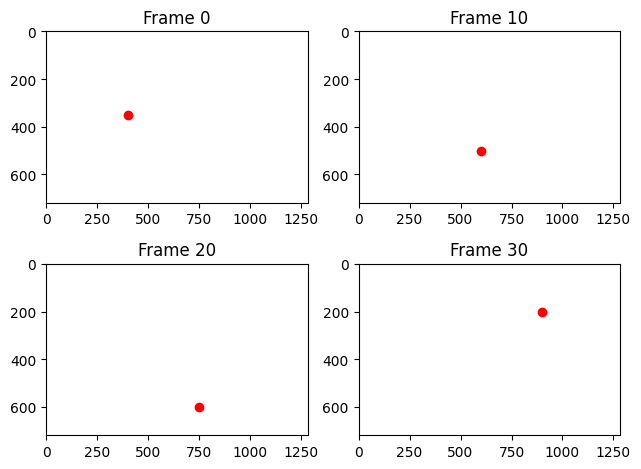

In [9]:
import matplotlib.pyplot as plt
# Create a list of frame numbers corresponding to each point
frame_numbers = queries[:,0].int().tolist()

fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

for i, (query, frame_number) in enumerate(zip(queries, frame_numbers)):
    ax = axs[i]
    ax.plot(query[1].item(), query[2].item(), 'ro') 
    
    ax.set_title("Frame {}".format(frame_number))
    ax.set_xlim(0, video.shape[4])
    ax.set_ylim(0, video.shape[3])
    ax.invert_yaxis()
    
plt.tight_layout()
plt.show()

We pass these points as input to the model and track them:

In [10]:
pred_tracks, __ = model(video, queries=queries[None])

Finally, we visualize the results with tracks leaving traces from the frame where the tracking starts.
Color encodes time:

In [11]:
vis = Visualizer(
    save_dir='./videos',
    linewidth=6,
    mode='cool',
    tracks_leave_trace=-1
)
vis.visualize(
    video=video,
    tracks=pred_tracks, 
    filename='queries');

Video saved to ./videos/queries_pred_track.mp4


In [12]:
HTML("""<video width="640" height="480" autoplay loop controls>
            <source src="./videos/queries_pred_track.mp4" type="video/mp4">
        </video>""")

## Points on a regular grid

### Tracking forward from the frame number x

Let's now sample points on a regular grid and start tracking from the frame number 20 with a grid of 30\*30. 

In [13]:
grid_size = 30
grid_query_frame = 20

In [14]:
pred_tracks, __ = model(video, grid_size=grid_size, grid_query_frame=grid_query_frame)

In [15]:
vis = Visualizer(save_dir='./videos', pad_value=100)
vis.visualize(
    video=video,
    tracks=pred_tracks, 
    filename='grid_query_20',
    query_frame=grid_query_frame);

Video saved to ./videos/grid_query_20_pred_track.mp4


Notice that tracking starts only from points sampled on a frame in the middle of the video. This is different from the grid in the first example:

In [16]:
HTML("""<video width="640" height="480" autoplay loop controls>
        <source src="./videos/grid_query_20_pred_track.mp4" type="video/mp4">
    </video>""")

### Tracking forward **and backward** from the frame number x

CoTracker is an online algorithm and tracks points only in one direction. However, we can also run it backward from the queried point to track in both directions: 

In [17]:
grid_size = 30
grid_query_frame = 20

Let's activate backward tracking:

In [18]:
pred_tracks, __ = model(video, grid_size=grid_size, grid_query_frame=grid_query_frame, backward_tracking=True)
vis.visualize(
    video=video,
    tracks=pred_tracks, 
    filename='grid_query_20_backward',
    query_frame=grid_query_frame);

Video saved to ./videos/grid_query_20_backward_pred_track.mp4


As you can see, we are now tracking points queried in the middle from the first frame:

In [19]:
HTML("""<video width="640" height="480" autoplay loop controls>
        <source src="./videos/grid_query_20_backward_pred_track.mp4" type="video/mp4">
    </video>""")

## Regular grid + Segmentation mask

Let's now sample points on a grid and filter them with a segmentation mask.
This allows us to track points sampled densely on an object because we consume less GPU memory.

In [20]:
import numpy as np
from PIL import Image
grid_size = 120

In [21]:
input_mask = '../assets/apple_mask.png'
segm_mask = np.array(Image.open(input_mask))

That's a segmentation mask for the first frame:

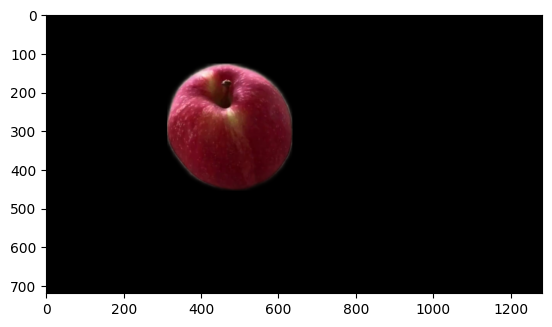

In [22]:
plt.imshow((segm_mask[...,None]/255.*video[0,0].permute(1,2,0).cpu().numpy()/255.))

In [23]:
pred_tracks, __ = model(video, grid_size=grid_size, segm_mask=torch.from_numpy(segm_mask)[None, None])
vis = Visualizer(
    save_dir='./videos',
    pad_value=100,
    linewidth=2,
)
vis.visualize(
    video=video,
    tracks=pred_tracks, 
    filename='segm_grid');

Video saved to ./videos/segm_grid_pred_track.mp4


We are now only tracking points on the object (and around):

In [24]:
HTML("""<video width="640" height="480" autoplay loop controls>
        <source src="./videos/segm_grid_pred_track.mp4" type="video/mp4">
    </video>""")

## Dense Tracks

### Tracking forward **and backward** from the frame number x

CoTracker also has a mode to track **every pixel** in a video in a **dense** manner but it is much slower than in previous examples. Let's downsample the video in order to make it faster: 

In [25]:
video.shape

torch.Size([1, 48, 3, 719, 1282])

In [26]:
import torch.nn.functional as F
video_interp = F.interpolate(video[0], [100,180], mode="bilinear")[None].cuda()

The video now has a much lower resolution:

In [27]:
video_interp.shape

torch.Size([1, 48, 3, 100, 180])

Again, let's track points in both directions. This will only take a couple of minutes:

In [28]:
pred_tracks, __ = model(video_interp, grid_query_frame=20, backward_tracking=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:07<00:00, 14.18s/it]


Visualization with an optical flow color encoding:

In [29]:
vis = Visualizer(
    save_dir='./videos',
    pad_value=20,
    linewidth=1,
    mode='optical_flow'
)
vis.visualize(
    video=video_interp,
    tracks=pred_tracks, 
    query_frame=grid_query_frame,
    filename='dense');

Video saved to ./videos/dense_pred_track.mp4


In [30]:
HTML("""<video width="320" height="240" autoplay loop controls>
        <source src="./videos/dense_pred_track.mp4" type="video/mp4">
    </video>""")

That's all, now you can use CoTracker in your projects!